### Convolutional layers
Convolutional neural networks use a particular type of layer called convolutional layer that can work on 3-dimensional volumes of data like images. The intuition behind those convolutional layers is that the important features are usually not specific to some locations of the image. For instance, if detecting lines is an important aspect of our network, we don’t need to learn to detect lines at every location of the image independently. Instead, we could simply learn a line detector that we slide over the image. This operation is called convolution.

### TensorFlow implementation
We will now see how to implement the simple convolutional neural network from above using TensorFlow.

#### Data preprocessing
Let’s start by loading and preprocessing the data. We saw in the previous unit that we can improve the learning process by centering the input values around zero. In our case, we are working with pixel values that range between 0 and 255. A common way to preprocess images before passing them to a ConvNet is to subtract 128 to each value and divide them by 255. With this simple procedure, we should get centered values that range between -0.5 and 0.5.

In [1]:
import numpy as np

# Load data
with np.load("c4_mnist-20k.npz", allow_pickle=False) as npz_file:
    mnist = dict(npz_file.items())

# Convert pixels into floating point numbers
data = mnist["data"].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255


In this code, we load the image pixels, convert them into floating point numbers and rescale them using the formula from above.

In this example, we will monitor the learning process using a validation set. We will use 19,500 images for training and the remaining 500 ones for evaluation. Let’s create these train and validation sets.

In [2]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Reshape images (28 by 28)
    data.reshape(-1, 28, 28, 1),  # Single channel (grayscale)
    mnist["labels"],
    test_size=500,
    random_state=0,
)

# Print shape
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)

Train: (19500, 28, 28, 1) (19500,)
Valid: (500, 28, 28, 1) (500,)


In this code, we reshape the flat matrix of image pixels back into 28x28x1 grids of values with the reshape() function from Numpy and get two 4-dimensional arrays of values X_train and X_test with respectively 19,500 and 500 images.

Note: The last dimension, in this case representing the grayscale channel, is very important for ConvNets. It needs to be specified even if it only has a single value, as in our example.

### Create the convolutional layer
### Define the convolutional layer manually
We want to create our first convolutional layer. To achieve this, we will use the conv2d() function from the nn module. 2d because the convolution operation is done in two dimensions, regardless of the shape of the input image and kernel (whether they are 2d or 3d). We are sliding the kernel in the height/width dimensions to get a two dimensional output. The function takes the input values and a kernel variable with the kernel weights. Note that it expects 4d tensors in both cases.

* A [batch, in_height, in_width, in_channels] tensor for the input.
* A [filter_height, filter_width, in_channels, out_channels] tensor for the kernels.

We can pass the X_train from above for the input values, but we need to create the second tensor with the kernel weights.

In [3]:
import tensorflow as tf

# Define kernel matrix
kernel = tf.Variable(
    initial_value=tf.random.truncated_normal(
        shape=(5, 5, 1, 16),  # Sixteen 5x5x1 kernels
        stddev=0.01,  # Small standard deviation
        seed=0,
    )
)

In this code, we have created a Variable with the weights for the sixteen kernels and initialize it using a (truncated) normal distribution with a small standard deviation. Note that we have to specify the depth of the input values even if the images are 2-dimensional. For this reason, the shape of the kernels is 5x5x1 instead of 5x5, and the input images are 28x28x1 instead of 28x28.

We can now create the convolution operation with the conv2d() function. We can specify the stride and the padding with the stride and padding arguments. For the stride, we need to provide a list with one value for each dimension in the input, i.e., how the kernels move on the [batch, in_height, in_width, in_channels] input tensor. In our case, we set it to [1, 2, 2, 1] since we are doing a 2d convolution over the height/width axes.

In [4]:
# Convolutional layer
conv = tf.nn.conv2d(
    X_train, kernel, strides=[1, 2, 2, 1], padding="SAME"  # Stride: 2  # "same" padding
)
print(conv.shape)

(19500, 14, 14, 16)


The function creates a conv operation that produces sixteen 14x14 grids of values for each image. We can then add a variable with the biases and apply the activation function.

In [5]:
# Create biases (one per filter)
biases = tf.Variable(initial_value=tf.zeros(shape=[16]))

# Apply activation function
conv = tf.nn.relu(conv + biases)  # ReLU

Note that we create one bias for each kernel and add them to the output values using the + operator. TensorFlow will automatically add each bias to the relevant filter using broadcasting.

Creating convolutional layers using the code from above can quickly become complex. In particular with deep networks with several layers. For this reason, TensorFlow provides a simplified Conv2D() class in its kera.layers module that automatically creates all the variables and apply the relevant activation function. Let’s redefine our network with this class.

### Define convolutional layer using built-in class

In [6]:
# Convolutional layer
conv_layer = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv",  # Add name
)
conv_output = conv_layer(X_train)

print(conv_output.shape)

(19500, 14, 14, 16)


In [7]:
print(conv_layer.kernel.shape)
print(conv_layer.bias.shape)

(5, 5, 1, 16)
(16,)


This time, we pass the input variable, the number of filters, the stride and padding, the activation function and an initializer for the kernel weights. It’s interesting to note that we don’t have to repeat any values. This makes the network architecture much easier to edit, e.g., change the number of kernels or their size. One can extract the weights of all the sixteen kernels using the kernel class attribute and the biases using bias.

### Max pooling layer
The keras.layers module also provides a MaxPool2D class to create max pooling layers. The layer takes the 4d input tensor, the pool size, the stride, and padding.

In [8]:
# Max pooling layer
pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="SAME")
pool_output = pool_layer(conv_output)

print(pool_output.shape)

(19500, 7, 7, 16)


As we can see, the max pooling layer reduced by half the dimensions of the input in the height/width axes and hence by 75% the number of values.

### Convolutional neural network
Let’s add the second convolutional and max pooling layers on top of the first ones with the Conv2D() and MaxPool2D classes.



In [9]:
# 2nd convolutional layer
conv_layer2 = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv2",
)
conv_output2 = conv_layer2(pool_output)

# 2nd max pooling layer
pool_output2 = pool_layer(conv_output2)

print(conv_output2.shape)
print(pool_output2.shape)

(19500, 7, 7, 16)
(19500, 4, 4, 16)


This time, the convolutional layer doesn’t modify the dimension of the input since it uses the “same” padding strategy with a stride of 1. On the other hand, the max pooling layer reduces its dimensions, and we get sixteen 4x4 grids (256 output values). In a typical ConvNet architecture, we use these high-level features to solve our task. In our example, we will combine these values into ten output logits with a fully-connected layer.

But first, we need to flatten the 4x4x16 output volumes into flat vectors. To achieve this we can use the reshape() function from TensorFlow.

In [10]:
# Flatten output into a (batch_size, 256) matrix
flat_output = tf.reshape(pool_output2, [-1, 256])

print(flat_output.shape)

(19500, 256)


In this code, we pass the desired output shape to the function. This can be an issue in practice since it depends on the current ConvNet architecture. In particular, we would need to recompute and edit the number of features each time we modify the first convolutional and max pooling layers, e.g., increase the number of kernels, change their size and so on.

To avoid this, we can use the Flatten class from the keras.layers module which automatically computes the shape of the input and flattens the dimensions (except the first one which is the batch size).

In [11]:
# Flatten output
flat_layer = tf.keras.layers.Flatten()
flat_output = flat_layer(pool_output2)

print(flat_output.shape)

(19500, 256)


Now that we have a set of 256 features for each image, let’s build the final classifier using a fully-connected layer.



In [12]:
# Output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1, seed=0),
    bias_initializer=tf.zeros_initializer(),
    name="dense",
)
logits_output = logits_layer(flat_output)

print(logits_output.shape)

(19500, 10)


#### Loss function and training operations
Finally, let’s define the loss function and the training operations. This time, we will use the Adam optimizer. Adam is a very popular algorithm that was introduced in 2015. It’s now one of the default choices to optimize neural networks. We won’t go into the details of how the algorithm works, but one of the key differences with stochastic gradient descent (SGD) is that it maintains a different learning rate for each parameter in the network.

Adam optimizer has several parameters, but we will only adjust the principal learning rate. We will use the default learning rate of 0.001 from the documentation.



In [13]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define functions used to train the graph

# Compute the logits
@tf.function
def compute_logits(x):
    conv_output = conv_layer(x)
    pool_output = pool_layer(conv_output)
    conv_output2 = conv_layer2(pool_output)
    pool_output2 = pool_layer(conv_output2)
    flat_output = flat_layer(pool_output2)
    logits_output = logits_layer(flat_output)
    return logits_output


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x)
        loss = compute_loss(y, logits)
    # Concatenate the trainable variables in one list using the '+' operation on lists
    variables = (
        conv_layer.trainable_variables
        + conv_layer2.trainable_variables
        + logits_layer.trainable_variables
    )
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

The main difference from the previous unit is in the compute_logits() function where we are now using the layers created above to build our convolutional neural network.

### Train network
Let’s train our network. We will use the random batch generator from the previous unit.

In [14]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

We can now train our network for ten epochs using small batches of data.

In [15]:
# Validation accuracy
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(10):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

# Get 1st conv. layer kernels
kernels = conv_layer.kernel

Epoch 1 - valid: 0.922 train: 0.752 (mean)
Epoch 2 - valid: 0.956 train: 0.937 (mean)
Epoch 3 - valid: 0.962 train: 0.952 (mean)
Epoch 4 - valid: 0.968 train: 0.960 (mean)
Epoch 5 - valid: 0.972 train: 0.967 (mean)
Epoch 6 - valid: 0.970 train: 0.970 (mean)
Epoch 7 - valid: 0.976 train: 0.974 (mean)
Epoch 8 - valid: 0.976 train: 0.975 (mean)
Epoch 9 - valid: 0.974 train: 0.976 (mean)
Epoch 10 - valid: 0.982 train: 0.980 (mean)


In this code, we run the training operation and save the accuracy on each batch of data. After each epoch, we evaluate the network on the validation set and compare its validation accuracy to the mean of the train accuracy values. In our case, the train and validation accuracy values are close to each other which is a good sign that the network is not overfitting. At the end of the training process, we save the weights of the kernels from the first convolutional layer in a kernels variable to visualize them.

But first, let’s plot the validation accuracy values.

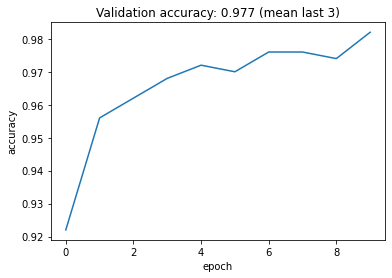

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title(
    "Validation accuracy: {:.3f} (mean last 3)".format(
        np.mean(valid_acc_values[-3:])  # Last three values
    )
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

We get a final validation accuracy around 98%.

### Plot filters
Let’s visualize the 16 kernels from the first layer. To achieve this, we need to extract the 5x5 kernel weights from the kernels variable which is an array of shape (5, 5, 1, 16).

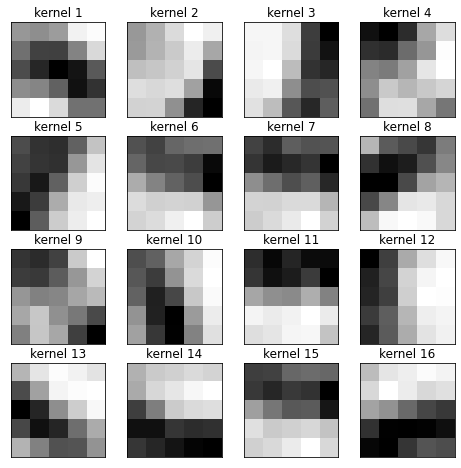

In [17]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the 16 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel
    kernel = kernels[:, :, :, i].numpy()

    # Kernels are 5x5x1 (height, width, channels)
    # Remove last dimension
    kernel = kernel[:, :, 0]  # (5, 5) kernel

    # Plot kernel with imshow()
    axis.set_title("kernel {}".format(i + 1))
    axis.imshow(kernel, cmap=plt.cm.gray_r)
    axis.get_xaxis().set_visible(False)  # disable x-axis
    axis.get_yaxis().set_visible(False)  # disable y-axis

plt.show()
